In [3]:
#Import Libraries
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import os
import cv2
import time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
print(tf.__version__)

2.9.2


In [5]:
IMG_HEIGHT = 1008
IMG_WIDTH = 756
BATCH_SIZE = 16



TRAINING_DATA = tf.keras.preprocessing.image_dataset_from_directory(
    "/directory",
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    validation_split=0.2,
    subset="training",
    seed=1024
)

VALIDATION_DATA = tf.keras.preprocessing.image_dataset_from_directory(
    "/directory",
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    validation_split=0.2,
    subset="validation",
    seed=1024
)

TRAINING_LABELS = TRAINING_DATA.map(lambda image, label: label)
VALIDATION_LABELS = VALIDATION_DATA.map(lambda image, label: label)





Found 2048 files belonging to 51 classes.
Using 1639 files for training.
Found 2048 files belonging to 51 classes.
Using 409 files for validation.


In [6]:
print("Training images shape : ",TRAINING_DATA.element_spec[0].shape)
print("Training labels shape : ",TRAINING_LABELS.element_spec.shape)
print("Validation images shape : ",VALIDATION_DATA.element_spec[0].shape)
print("Validation labels shape : ",VALIDATION_LABELS.element_spec.shape)

Training images shape :  (None, 1008, 756, 3)
Training labels shape :  (None, 51)
Validation images shape :  (None, 1008, 756, 3)
Validation labels shape :  (None, 51)


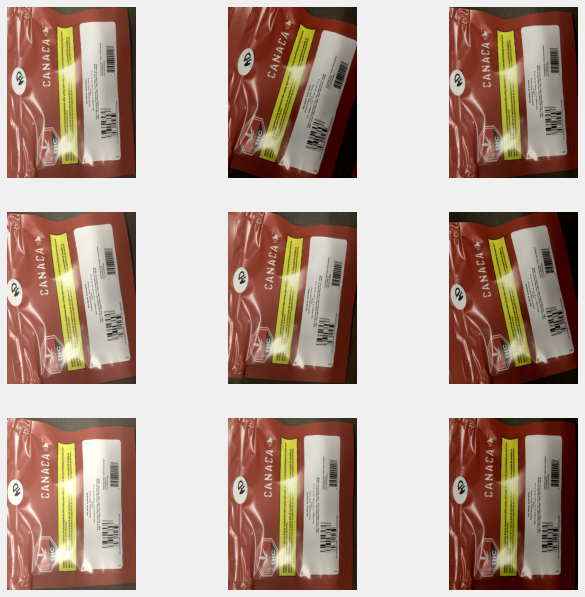

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=(-0.05, 0.05)),
        layers.RandomZoom((-0.05,-0.15),(-0.05,-0.15)),
        tf.keras.layers.RandomBrightness(factor=0.1),
        tf.keras.layers.RandomBrightness(factor=0.1)  
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in TRAINING_DATA.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
# Apply `data_augmentation` to the training images.
TRAINING_DATA = TRAINING_DATA.map(
   lambda img, label: (data_augmentation(img), label),
   num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
TRAINING_DATA = TRAINING_DATA.prefetch(tf.data.AUTOTUNE)
VALIDATION_DATA = VALIDATION_DATA.prefetch(tf.data.AUTOTUNE)

In [9]:
#Build Model
MODEL = tf.keras.Sequential(
    [
      
        #Rescale the images from 0-255 to 0-1 to make it easier to process
        tf.keras.layers.Rescaling(1./255),
        
        #Convolutional Layer 1
        tf.keras.layers.Conv2D(32, 3, activation='relu'),#Convolutional Layer
        tf.keras.layers.MaxPooling2D(),#Max Pooling Layer
        
        #Convolutional Layer 2
        tf.keras.layers.Conv2D(32, 3, activation='relu'),#Convolutional Layer
        tf.keras.layers.MaxPooling2D(),#Max Pooling Layer
        
        #Convolutional Layer 3
        tf.keras.layers.Conv2D(32, 3, activation='relu'),#Convolutional Layer
        tf.keras.layers.MaxPooling2D(),#Max Pooling Layer
        
        #Flatten the data for the Dense Layers
        tf.keras.layers.Flatten(),
        
        #Dense Layer 1
        tf.keras.layers.Dense(128, activation='relu'),
     

        
        # This dense layer must contain the number of subdirectories
        # ex) if categories are cats and dogs, x = 2
        # ex) if categories are cats dogs, and birds x = 3     
     #TO DO: change to a integer variable of the number of subdirectories
        #Dense Layer 2
        tf.keras.layers.Dense(51)
     

    ]
)






In [10]:
#Compile Model/Preprocess Model
MODEL.compile(
    optimizer='adam',
    loss = tf.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    
)


In [11]:
#Getting Log Data
# We can hopefully see how it works easier with this
NAME = "cannabis-packaging-756x1008-{}".format(int(time.time()))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [12]:
#Train Model
#This is where we can change the number of times it runs
MODEL.fit(
   TRAINING_DATA,
    epochs=8, 
    callbacks=[tensorboard],
    validation_data = VALIDATION_DATA
)

Epoch 1/8
103/103 [==============================] - 117s 961ms/step - loss: 3.6776 - accuracy: 0.3026 - val_loss: 1.0079 - val_accuracy: 0.7311
Epoch 2/8
103/103 [==============================] - 52s 456ms/step - loss: 0.5982 - accuracy: 0.8505 - val_loss: 0.3805 - val_accuracy: 0.8851
Epoch 3/8
103/103 [==============================] - 52s 453ms/step - loss: 0.1671 - accuracy: 0.9555 - val_loss: 0.3786 - val_accuracy: 0.8973
Epoch 4/8
103/103 [==============================] - 52s 459ms/step - loss: 0.2298 - accuracy: 0.9597 - val_loss: 0.5675 - val_accuracy: 0.8289
Epoch 5/8
103/103 [==============================] - 52s 465ms/step - loss: 0.1597 - accuracy: 0.9549 - val_loss: 0.2229 - val_accuracy: 0.9267
Epoch 6/8
103/103 [==============================] - 52s 458ms/step - loss: 0.0819 - accuracy: 0.9774 - val_loss: 0.2898 - val_accuracy: 0.9218
Epoch 7/8
103/103 [==============================] - 52s 458ms/step - loss: 0.1239 - accuracy: 0.9701 - val_loss: 0.3177 - val_accuracy

In [13]:
MODEL.evaluate(VALIDATION_DATA)

26/26 [==============================] - 5s 140ms/step - loss: 0.2722 - accuracy: 0.9413


[0.27222466468811035, 0.9413203001022339]

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in TRAINING_DATA.take(1):
    classificatiions = MODEL(images)
    print(classificatiions)

tf.Tensor(
[[ 4.44224358e+00 -6.08709955e+00  1.92945492e+00 -1.71264744e+00
   4.61170959e+00  6.73866129e+00 -7.33012629e+00 -1.08245869e+01
  -3.82235241e+00 -7.80488062e+00  2.58404560e+01  1.11986077e+00
  -6.66588902e-01 -4.25115919e+00 -5.37745285e+00 -1.04644670e+01
  -1.18472803e+00  8.03453386e-01 -6.44045353e+00 -3.26456571e+00
   4.62262201e+00  1.80819452e+00 -1.17513208e+01 -3.69036031e+00
  -3.83937335e+00 -2.31590748e+00  3.12916398e+00  1.11849558e+00
   3.93390107e+00  1.20603771e+01 -7.57916307e+00  8.69690609e+00
   1.09871376e+00  5.52129328e-01 -1.13238783e+01 -2.61709046e+00
  -1.98424256e+00  9.26641178e+00 -3.85345292e+00 -9.25111294e+00
  -6.97500753e+00 -1.01329308e+01  2.34511271e-01 -4.92027283e-01
  -1.34290934e+01 -1.07095680e+01 -4.82784510e+00 -7.29377413e+00
  -8.09573174e+00 -1.14134026e+01  4.62044382e+00]
 [-7.02566877e-02 -1.11162138e+01  2.11217403e+00 -9.52510357e-01
  -8.53572273e+00  1.92705226e+00 -8.19660950e+00 -3.98307157e+00
   3.65625620e

<Figure size 720x720 with 0 Axes>

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(MODEL)
ARC_Model_Front_1 = converter.convert()

with open("ARC_Model_Front_1.tflite", 'wb') as f:
  f.write(ARC_Model_Front_1)

In [17]:
MODEL.save("ARC_Model_Front_1.h5")